# Clip a satellite image to AOI and reproject into a new CRS


In [10]:
import rasterio
from matplotlib import pyplot as plt

# This notebook explores a single 4 band (blue, green, red, NIR) PlanetScope scene in a UTM projection.
image_file = "Rome_analytic.tif"

# Use Rasterio to open the image.
satdat = rasterio.open(image_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


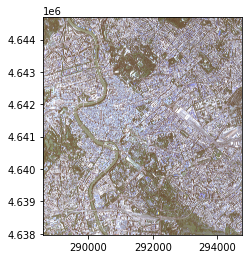

<AxesSubplot: >

In [11]:
# rasterio.plot.show is a shortcut to matplotlib plotting

from rasterio.plot import show
show(satdat)

## Using a mask to cut raster along boundary

In this exercise we're going to clip a fullsized PlanetScope dataset to an area of interest (AOI) polygon. Because this AOI is a vector dataset (versus raster), we'll use Rasterio's sister-library, Fiona, to read the geoJSON dataset:

In [6]:
pip install geopandas

     |████████████████████████████████| 1.1 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 18.5 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.1 MB 3.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [17]:
import fiona

# use fiona to open our AOI GeoJSON
with fiona.open('aoi.geojson') as f:
    aoi = [feature["geometry"] for feature in f]

![masked.png](masked.png)
_Area of Interest (shown here in red) displayed over a portion of the complete dataset_

In order to clip our original raster to the boundary defined by the AOI, we'll use rasterio's `mask` function. This will create a copy of our original dataset, with all pixels outside of the input AOI shape set to `nodata` values.

In [18]:
# import rasterio's mask tool
from rasterio.mask import mask

# apply mask with crop=True to crop the resulting raster to the AOI's bounding box
with rasterio.open(image_file) as img:
    clipped, transform = mask(img, aoi, crop=True)
    
print(clipped.shape)

(4, 1478, 2216)


Using a copy of the metadata from our original raster dataset, we can write a new geoTIFF containing the new, clipped raster data:

In [23]:
# use the metadata from our original mosaic
meta = img.meta.copy()

# update metadata with new, clipped mosaic's boundaries
meta.update({"transform": transform,
    "height":clipped.shape[1],
    "width":clipped.shape[2]})

# write the clipped-and-cropped dataset to a new GeoTIFF
with rasterio.open('clipped.tif', 'w', **meta) as dst:
    dst.write(clipped)

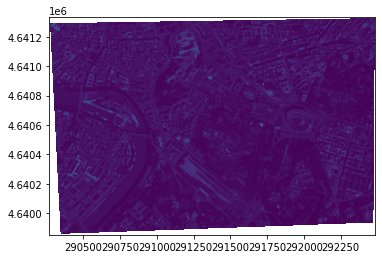

<AxesSubplot: >

In [24]:
clipped_img = rasterio.open("clipped.tif")
show(clipped_img)

## Reprojecting with rasterio

Now let's reproject our clipped dataset: for this example, we'll reproject into EPSG 4326

In [42]:
from rasterio.warp import calculate_default_transform, reproject

# define our target CRS - rasterio will accept any CRS that can be defined using WKT
target_crs = 'EPSG:4326'

In [39]:
pip install rasterio

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install rioxarray 

     |████████████████████████████████| 53 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 3.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Transforms

In order to translate pixel coordinates in a raster dataset into coordinates that use a spatial reference system, an **affine transformation** must be applied to the dataset. This **transform** is a matrix used to translate rows and columns of pixels into (x,y) spatial coordinate pairs. Every spatially referenced raster dataset has an affine transform that describes its pixel-to-map-coordinate transformation.

In order to reproject a raster dataset from one coordinate reference system to another, rasterio uses the **transform** of the dataset: this can be calculated automatically using rasterio's `calculate_default_transform` method:

In [43]:
# calculate a transform and new dimensions using our dataset's current CRS and dimensions
transform, width, height = calculate_default_transform(clipped_img.crs, 
                                                      target_crs, 
                                                       clipped_img.width, 
                                                       clipped_img.height, 
                                                       *clipped_img.bounds)

CRSError: The WKT could not be parsed. OGR Error code 6

Using a copy of the metadata from the clipped raster dataset and the transform we defined above, we can write a new geoTIFF containing the reprojected and clipped raster data:

In [10]:
# Copy the metadata from the clipped dataset
metadata = clipped_img.meta.copy()

# Change the CRS, transform, and dimensions in metadata to match our desired output dataset
metadata.update({'crs':target_crs, 
                'transform':transform,
                'width':width,
                'height':height})

In [11]:
# apply the transform & metadata to perform the reprojection
# here we're saving the output to a new 'clipped_4326.tif' file
with rasterio.open('clipped_4326.tif', 'w', **metadata) as reprojected:
    for band in range(1, clipped_img.count + 1):
        reproject(
            source=rasterio.band(clipped_img, band),
            destination=rasterio.band(reprojected, band),
            src_transform=clipped_img.transform,
            src_crs=clipped_img.crs,
            dst_transform=transform,
            dst_crs=target_crs
        )

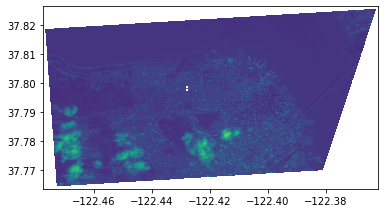

<AxesSubplot:>

In [12]:
# take a look at our clipped & reprojected dataset
reproj = rasterio.open("clipped_4326.tif")
show(reproj)